# Cluster POIs using DBSCAN

In [1]:
import pandas as pd
from geopandas import GeoDataFrame
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
from time import time
import pysal
from shapely.geometry import Point
import shapely as shp
import folium

/home/user/miniconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
input_dir = '../data/input/'
output_dir = '../data/output/'

## Read input file

In [3]:
pois = pd.read_pickle(input_dir + 'london_pois_gdf.pkl')
print("POIs loaded: %s" % (len(pois.index)))
pois.head()

POIs loaded: 85187


,poi_id,poi_name,poi_kwds,geometry
0,N10287073,Wembley Central,"[transport, station]",POINT (518206.2277696228 185095.8309513291)
1,N10370938,Hadley Wood,"[transport, station]",POINT (526215.3641507154 198221.9922744819)
2,N10371887,Alexandra Palace,"[transport, station]",POINT (530280.7522176408 190456.0047157237)
3,N10606316,St John Street / Goswell Road,"[transport, busstop]",POINT (531464.3598053379 183078.4395275304)
4,N10713594,Carshalton Beeches,"[transport, station]",POINT (527562.7459662389 163605.7092331609)


## Optionally filter POIs by keywords

In [4]:
kwd_filter = set(['food'])
#kwd_filter = set([])

In [5]:
pois = pois[pois['poi_kwds'].map(lambda x: bool(kwd_filter & set(x)) if len(kwd_filter) > 0 else True)]
print("POIs filtered: %s" % (len(pois.index)))
pois.head()

POIs filtered: 16535


,poi_id,poi_name,poi_kwds,geometry
19,N12242503,Railway Bell,"[food, pub]",POINT (540576.8896114922 190077.5369581918)
20,N12243302,The George,"[food, pub]",POINT (540644.106952635 188295.6113788032)
21,N12245485,"The Eagle, Toby Carvery","[food, pub]",POINT (540093.8806968946 189074.1681362605)
40,N451152,The Dignity,"[food, pub]",POINT (525136.1065181275 190654.6704870929)
41,N451153,Central Restaurant,"[food, restaurant]",POINT (525209.3537744763 190788.9183128849)


## Prepare coordinates for clustering

In [6]:
pois["lon"] = pois['geometry'].map(lambda p: p.x)
pois["lat"] = pois['geometry'].map(lambda p: p.y)
coords = pois[['lon', 'lat']].values
pois = pois.drop(columns=['lon', 'lat'])
print(coords)
print('\nArray size %s' % len(coords))

[[540576.88961149 190077.53695819]
 [540644.10695263 188295.6113788 ]
 [540093.88069689 189074.16813626]
 ...
 [535249.50894241 178658.80609098]
 [529878.71872102 181102.24560607]
 [530185.45061735 181210.6322924 ]]

Array size 16535


## Examine distances of each POI to its nearest neighbor

### Get a list of unique coordinates

In [7]:
coords_unique = [' '.join(str(e) for e in x) for x in coords]
coords_unique = set(coords_unique)
coords_unique = [list(map(float, x.split())) for x in coords_unique]
print('Total coords: %s' % len(coords))
print('Unique coords: %s' % len(coords_unique))

Total coords: 16535
Unique coords: 16532


### Find the nearest neighbor of each point

In [8]:
k = 1

In [9]:
t0 = time()
weights_knn = pysal.weights.KNN(coords_unique, k=k)
print("Done in %0.3fs." % (time() - t0))

Done in 9.842s.


### Examine the nearest neighbor distances

In [10]:
t0 = time()
d = list()
for i in range(len(coords_unique)):
    p = Point(coords_unique[i])
    nn = Point(coords_unique[weights_knn.neighbors[i][0]])
    d.append(p.distance(nn))
d = pd.Series(d)
print(d.describe())
print("Done in %0.3fs." % (time() - t0))

count    16532.000000
mean        55.560728
std        123.369814
min          0.129255
25%          9.741204
50%         19.745812
75%         41.362957
max       2268.288813
dtype: float64
Done in 1.974s.


## Examine number of neighbors of each POI within a given distance

### Select a distance threshold

In [11]:
dist_threshold = 200

### Compute the neighbors of each point

In [12]:
t0 = time()
weights_dist = pysal.weights.DistanceBand(coords_unique, threshold=dist_threshold)
print("Done in %0.3fs." % (time() - t0))

/home/user/miniconda3/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 1016 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/home/user/miniconda3/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 14, 28, 72, 92, 131, 134, 138, 150, 182, 183, 192, 194, 200, 206, 239, 240, 241, 246, 334, 349, 358, 381, 384, 385, 393, 400, 422, 428, 438, 484, 492, 502, 533, 540, 554, 557, 570, 585, 606, 617, 623, 654, 668, 687, 713, 791, 802, 845, 849, 856, 880, 903, 914, 918, 925, 969, 972, 985, 988, 990, 1032, 1049, 1054, 1098, 1107, 1129, 1161, 1162, 1175, 1177, 1193, 1227, 1231, 1233, 1272, 1275, 1329, 1355, 1386, 1387, 1391, 1404, 1418, 1420, 1500, 1515, 1520, 1527, 1531, 1534, 1555, 1564, 1593, 1608, 1611, 1620, 1633, 1656, 1665, 1734, 1746, 1756, 1776, 1806, 1808, 1816, 1838, 1840, 1843, 1858, 1869, 1870, 1876, 1902, 1942, 1954, 1963, 1964, 1993, 2004, 2022, 2037, 2038, 2045, 2065, 2072, 2095, 

Done in 76.947s.


### Examine the number of neighbors

In [13]:
n = list()
for i in range(len(coords_unique)):
    n.append(len(weights_dist[i]))
n = pd.Series(n)
print(n.describe())

count    16532.000000
mean        27.348052
std         35.086932
min          0.000000
25%          6.000000
50%         16.000000
75%         35.000000
max        265.000000
dtype: float64


## Set DBSCAN parameters eps and minPts

In [14]:
eps = 200
minPts = 35

## Run DBSCAN

In [15]:
t0 = time()
db = DBSCAN(eps=eps, min_samples=minPts).fit(coords)
print("Done in %0.3fs." % (time() - t0))
labels = db.labels_
num_clusters = len(set(labels))
print('Number of clusters: %d' % num_clusters)

Done in 0.446s.
Number of clusters: 39


## Add cluster labels to initial POIs

In [16]:
pois['label'] = labels
clustered_pois = pois[pois.label > -1]
clustered_pois.head(20)

,poi_id,poi_name,poi_kwds,geometry,label
64,N15262028,The Monkey Puzzle,"[food, pub]",POINT (527091.723903697 181306.6747058815),4
102,N108042,The Jeremy Bentham,"[food, pub]",POINT (529446.6497902106 182160.7722375459),1
188,N21392280,Hoop and Grapes,"[food, pub]",POINT (531592.5927679141 181319.9297292959),0
194,N21686579,White Swan,"[food, pub]",POINT (531634.0680557776 181311.9570608565),0
196,N21693791,The Saint,"[food, pub]",POINT (531954.3395298481 181283.6196751572),0
232,N21593232,The Knights Templar,"[food, pub]",POINT (531120.2842691645 181290.7398162421),0
233,N21593236,Ship Tavern,"[food, pub]",POINT (530597.2122357603 181489.063327418),1
234,N21593237,Bar Polski,"[food, bar]",POINT (530614.0093231115 181501.9135728221),1
235,N21593238,All Bar One,"[food, pub]",POINT (530591.6105849405 181389.0705907869),1
255,N25471087,Marquess of Anglesey,"[food, pub]",POINT (530475.1425937477 180987.6412087218),1


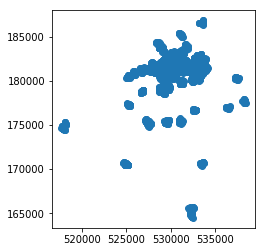

In [17]:
clustered_pois.plot()

## Save clusters

In [18]:
clustered_pois.to_csv(output_dir + 'pois_dbscan_output.csv')
clustered_pois.to_pickle(output_dir + 'pois_dbscan_output_gdf.pkl')

## Compute and visualize cluster borders

In [19]:
cluster_borders = clustered_pois.groupby(['label'], sort=False)['geometry'].agg([list, np.size])
geom = [shp.geometry.MultiPoint(x).convex_hull for x in cluster_borders['list']]
cluster_borders = GeoDataFrame(cluster_borders, crs=pois.crs, geometry=geom).drop(columns=['list'])

In [20]:
map_center = [51.507222, -0.1275] # London
m = folium.Map(location=map_center, zoom_start=12, tiles='OpenStreetMap', width=800, height=600)
folium.GeoJson(cluster_borders).add_to(m)
m